In [1]:
! pip install pycbc
! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc

**Challenge 1, Assignment set 1**

● Use the data file "challenge1.gwf". The channel name is "H1:CHALLENGE1".

● The data are white, Gaussian noise containing a simulated BBH signal.

1. Load the data into memory. What are the sampling rate and duration of the data?
2. Plot the data in the time-domain.
3. Plot a spectrogram (or q-transform) of the data, and try to identify the signal.
4. What is the time of the merger?

In [2]:
# -- for pycbc
from pycbc import frame
pycbc_strain = frame.read_frame('challenge1.gwf', 'H1:CHALLENGE1')

/usr/local/lib/python3.10/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [3]:
# -- for gwpy
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt

In [4]:
# Load the data
data = TimeSeries.read('challenge1.gwf', channel='H1:CHALLENGE1')

# 1. Determine the sampling rate and duration
sampling_rate = data.sample_rate.value
duration = data.duration.value

print("Sampling Rate:", sampling_rate, "Hz")
print("Duration:", duration, "seconds")

Sampling Rate: 4096.0 Hz
Duration: 128.0 seconds


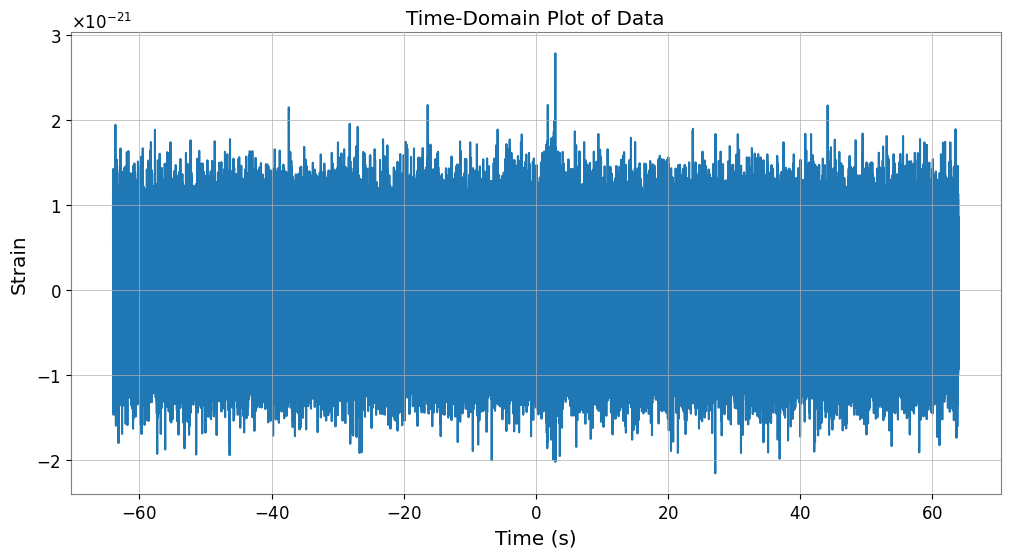

In [5]:
# 2. Plot the data in the time-domain
plt.figure(figsize=(12, 6))
plt.plot(data.times, data)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Time-Domain Plot of Data')
plt.grid(True)
plt.show()

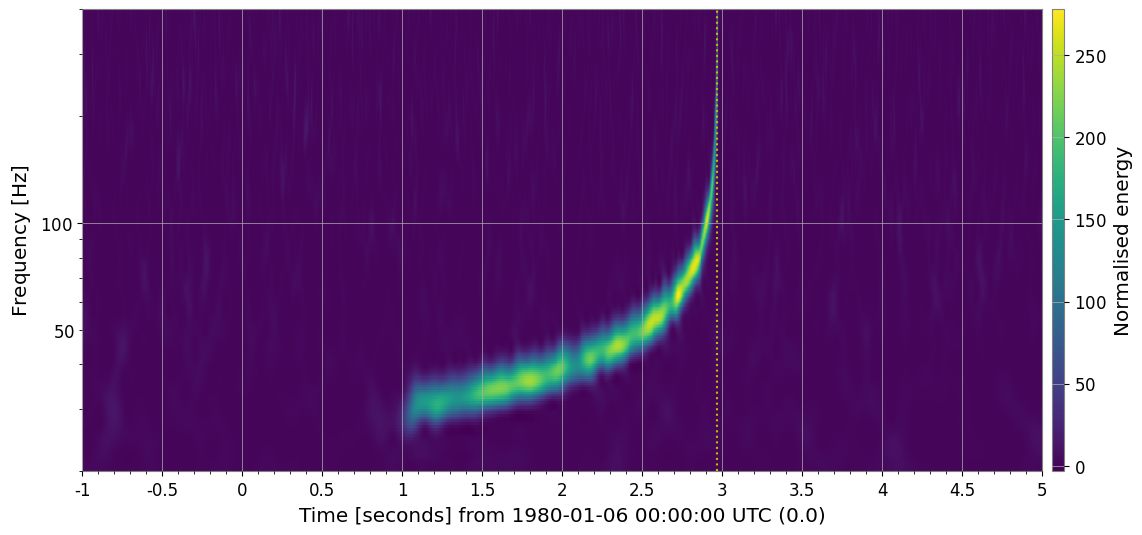

In [7]:
# 3. Plot q-transform of the data
hq = data.q_transform(frange=(20, 400), qrange=(10, 15), outseg=(-1,5))
plot = hq.plot()
ax = plot.gca()
ax.set_yscale('log')
t_est=2.97 # 4. Estimated time of merger
plt.axvline(x=t_est, color='y', linestyle=':')
ax.colorbar(label="Normalised energy")

We approximate the time of the merger to be at t= 2.97 s

**Challenge 2, Assignment set 1**

● Use the data file "challenge2.gwf", with channel name "H1:CHALLENGE2"

● The data contain a BBH signal with m1=m2=30 solar masses, spin = 0.

1. What is the approximative time of the merger? (Hint: a plot of the q-transform could help)
2. Generate a time-domain template waveform using approximate "SEOBNRv4_opt". with the same parameters as above. Plot this waveform.
3. Calculate a PSD of the data, and plot this on a log-log scale. Use axes ranging from 20 Hz up to the Nyquist frequency.
4. Use the template waveform and PSD to calculate the SNR time series. Plot the SNR time-series.
5. What is the matched filter SNR of the signal?

In [8]:
# Load the data
pycbc_strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')
gwpy_strain = TimeSeries.read('challenge2.gwf', channel="H1:CHALLENGE2")

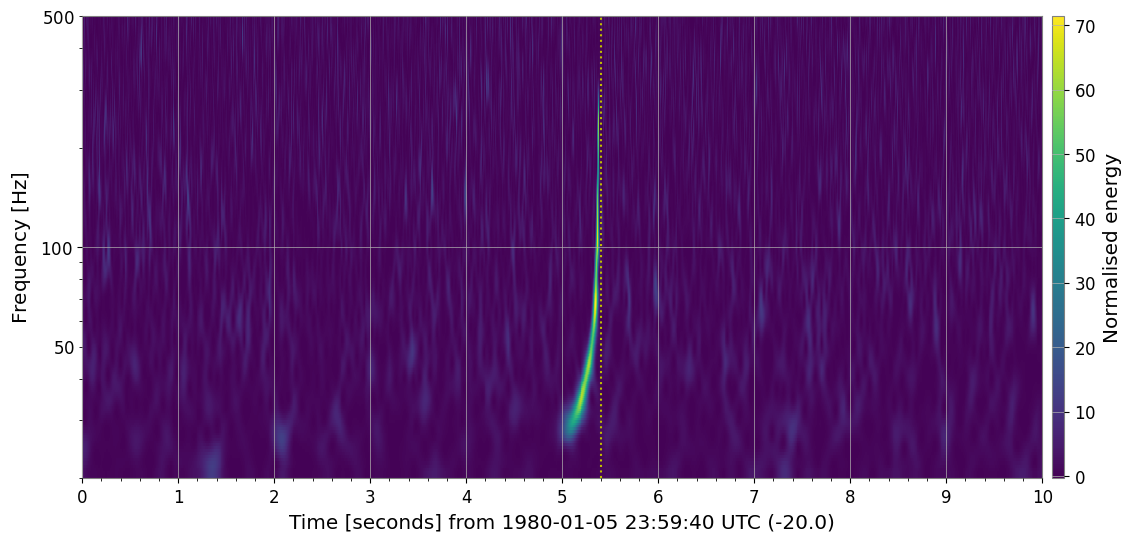

In [9]:
# Plotting q-transform
hq = gwpy_strain.q_transform(frange=(20, 500), qrange=(10, 15), outseg=(-20,-10))
plot = hq.plot()
ax = plot.gca()
ax.set_yscale('log')
t_est=-14.6 # 1. Estimated time of merger
plt.axvline(x=t_est, color='y', linestyle=':')
ax.colorbar(label="Normalised energy")

We approximate the time of the merger to be at t= -14.6 s

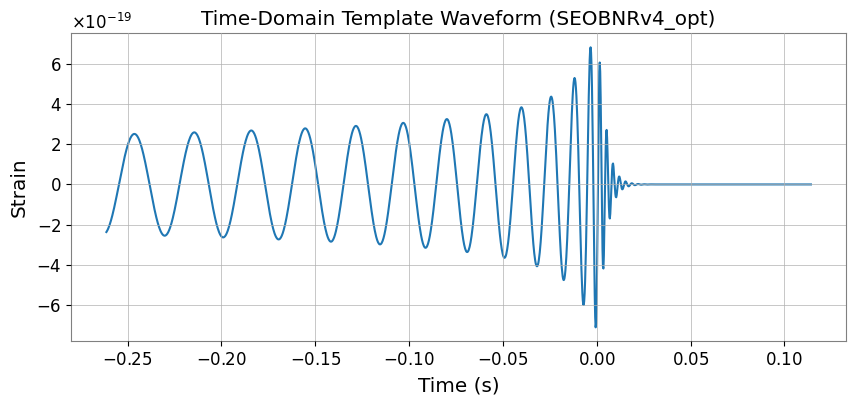

In [10]:
# 2. Generate waveform
from pycbc.waveform import get_td_waveform

# Parameters
mass1 = 30  # Solar masses
mass2 = 30  # Solar masses
spin1z = 0  # Dimensionless spin (z-component)

# Generate time-domain template waveform
hp, _ = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=mass1,
                         mass2=mass2,
                         spin1z=spin1z,
                         delta_t=1.0/4096,
                         f_lower=30)

# Plot waveform
plt.figure(figsize=(10, 4))
plt.plot(hp.sample_times, hp)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Time-Domain Template Waveform (SEOBNRv4_opt)')
plt.grid(True)
plt.show()

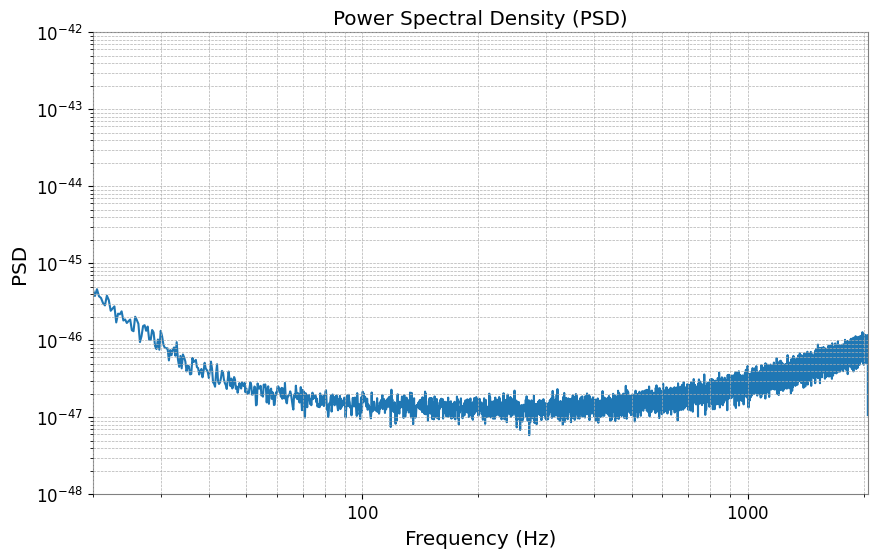

In [11]:
# 3. Calculate and plot PSD
import numpy as np
sampling_rate2 = gwpy_strain.sample_rate.value
nyqf=sampling_rate2/2
# Calculate the PSD
psd = gwpy_strain.psd(fftlength=4)

# Plot the PSD on a log-log scale
plt.figure(figsize=(10, 6))
plt.loglog(psd.frequencies.value, psd.value)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.title('Power Spectral Density (PSD)')
plt.xlim(20, nyqf)
plt.ylim(1e-48,1e-42)
plt.grid(True, which="both", ls="--")
plt.show()

In [12]:
# 4. Plot the SNR timeseries
from pycbc.psd import interpolate, inverse_spectrum_truncation
conditioned = pycbc_strain.crop(2, 2)
psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate), low_frequency_cutoff=15)


In [13]:
from pycbc.waveform import get_td_waveform
import pylab

m = 30 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# Resize the vector to match our data
hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)

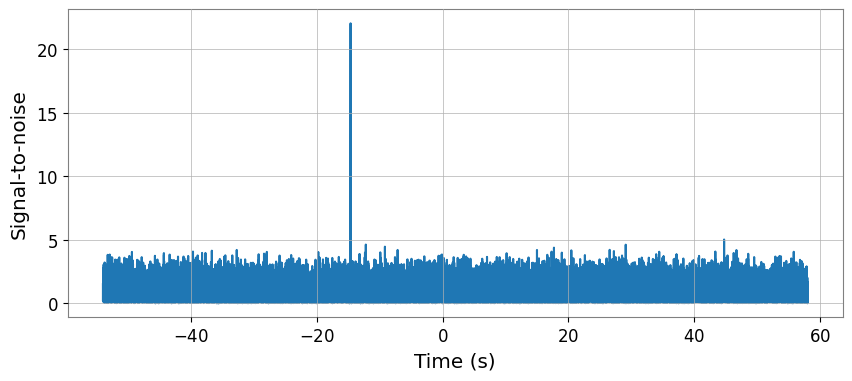

In [15]:
from pycbc.filter import matched_filter
snr = matched_filter(template, conditioned, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

In [16]:
# 5. Calculate matched filter SNR of the signal
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

We found a signal at -14.6328125s with SNR 22.055412799223898


**Challenge 2, Assignment set 2**

1.1 Load the data of the LIGO Hanford detector form.

1.2 Plot the noise power spectral density (PSD) of that data.

1.3 Test whether there is any gravitational wave signal present in the data or not? For this test you can assume the GW signal can produce only from equal mass binary systems with a range between 5 to 10. We assume a threshold on matched filter SNR of 8 to claim detection of GW.

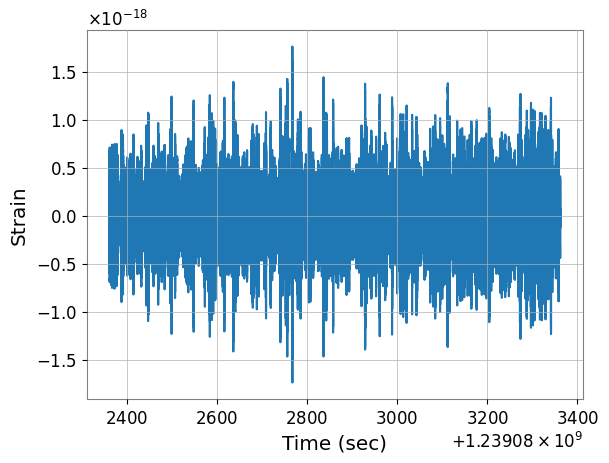

In [17]:
%matplotlib inline
import pylab
import numpy as np
import pycbc
from pycbc.types import TimeSeries
import matplotlib.pyplot as plt

# Load the data and create a TimeSeries object
d = np.load('noise_ts_4096Hz.npy')
time = d[:, 0]
strain = d[:, 1]
dt = time[1] - time[0]
data = TimeSeries(strain, delta_t=dt)

# Plot the data
plt.plot(time, data)
plt.xlabel('Time (sec)')
plt.ylabel('Strain')
plt.show()

In [18]:
# Calculate the sampling interval
dt = np.mean(np.diff(time))

# Calculate the sampling rate
sampling_rate3 = 1 / dt

print("Sampling rate:", sampling_rate, "Hz")

Sampling rate: 4096.0 Hz


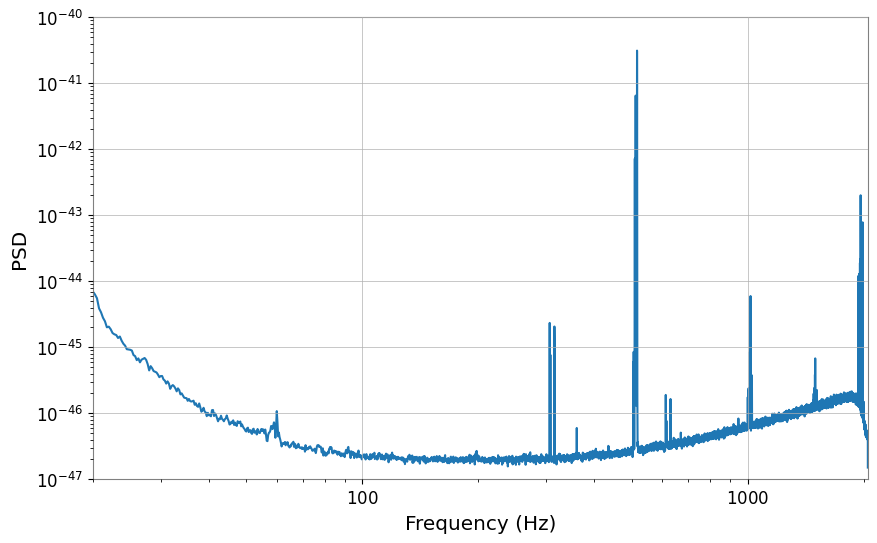

In [19]:
psd = data.psd(segment_duration=4)
nyqf=sampling_rate3/2
# Plot the PSD on a log-log scale
plt.figure(figsize=(10, 6))
plt.loglog(psd.sample_frequencies, psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.xlim(20, nyqf)
plt.ylim(1e-47,1e-40)
plt.show()

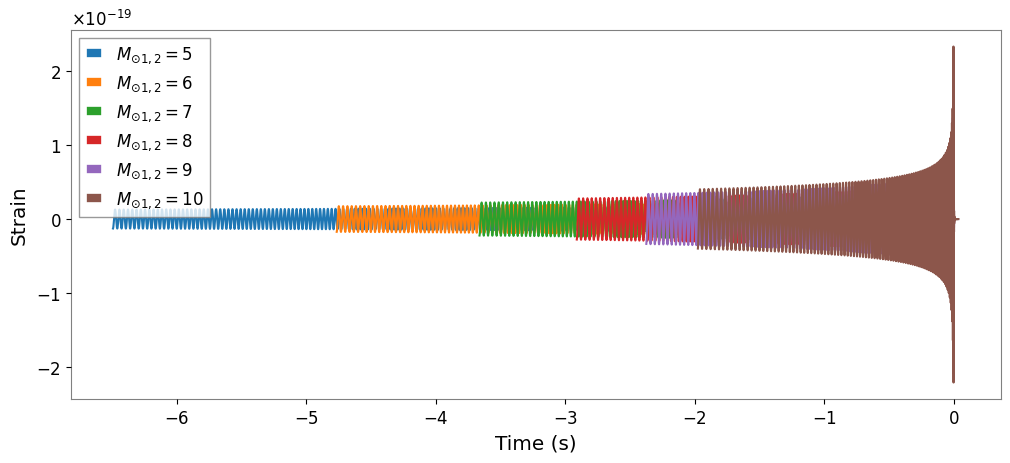

In [20]:
# Component mass of each binary component. We'll simplify here and assume that each
# component of the binary has the same mass. Again, units are in solar masses.
pylab.figure(figsize=pylab.figaspect(0.4))
for m in [5, 6, 7, 8, 9, 10]:
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=m,
                         mass2=m,
                         delta_t=1.0/4096,
                         f_lower=30)

    pylab.plot(hp.sample_times, hp, label='$M_{\odot 1,2}=%s$' % m)
pylab.legend()
pylab.grid()
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.show()

In [21]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
conditioned = data.crop(2, 2)
psdc = conditioned.psd(4)
psdc = interpolate(psd, conditioned.delta_f)
psdc = inverse_spectrum_truncation(psdc, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

In [22]:
for m in [5, 6, 7, 8, 9, 10]:
  hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=1.0/4096,
                     f_lower=20)

# Resize the vector to match our data
hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)

In [25]:
snr = matched_filter(template, conditioned, psd=psd, low_frequency_cutoff=20) # This worked before for me but is now giving an error that I do not know how to solve
snr = snr.crop(4 + 4, 4)
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time,
                                                    abs(snrp)))

ValueError: PSD delta_f does not match data

The SNR stays below 8, so we can conclude that there is only noise and no signal present.

2.1 Whiten the above data using its noise PSD. You can use PyCBC based function of the Welch method to estimate the PSD.

2.2 Construct a histogram of the whitened data and show that the whiten data follows a Gaussian distribution with zero mean.

In [48]:
from pycbc.types import TimeSeries
# 2.1 Whiten data
psdc[0]=psdc[1]
psdc[len(psdc)-1]=psdc[len(psdc)-2]
white_data = (conditioned.to_frequencyseries() / psdc**0.5).to_timeseries()
white_data=white_data.crop(4,4)

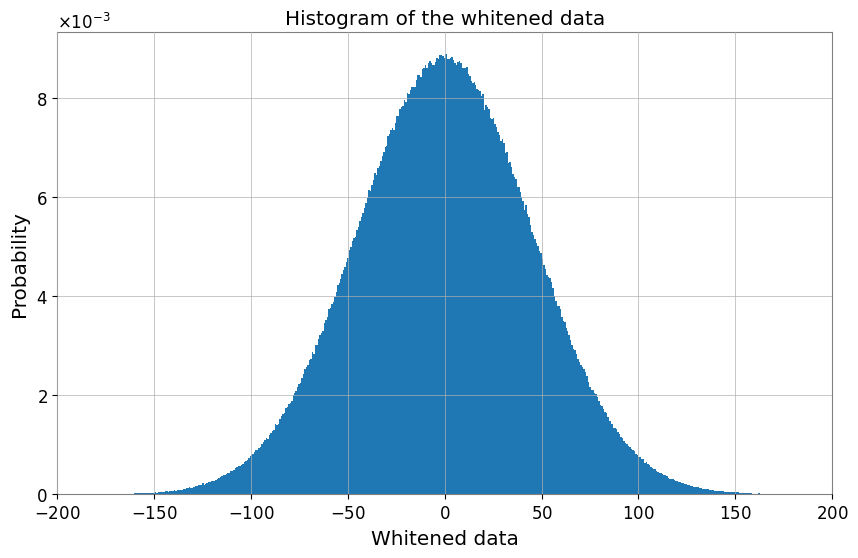

In [50]:
# 2.2 Plotting histogram of whitened data
plt.figure(figsize=(10, 6))
plt.hist(white_data, bins="auto", density=True, label='Whitened Data')
plt.xlim(-200,200)
plt.title("Histogram of the whitened data")
plt.xlabel("Whitened data")
plt.ylabel("Probability")
plt.show()

3. Test to show that the stationary assumption does not hold

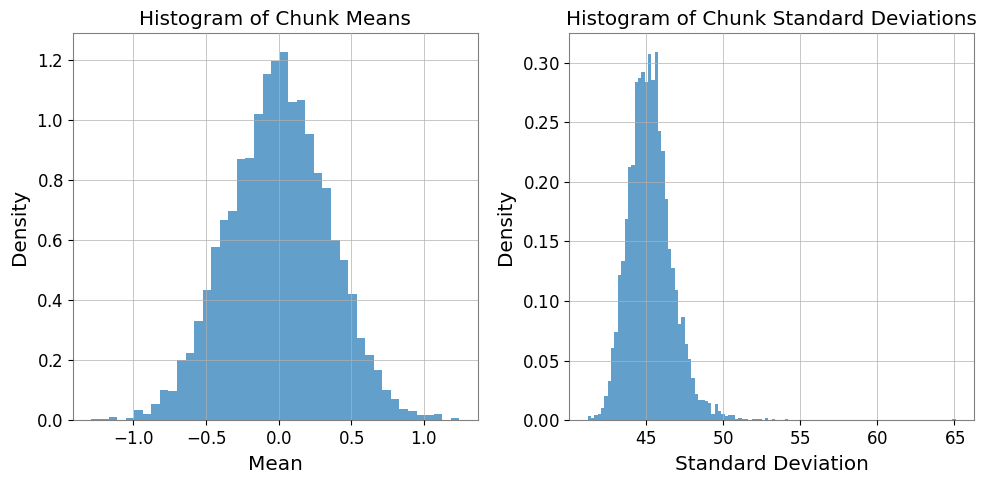

In [51]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

# Divide data into chunks (adjust chunk size as needed)
chunk_size = 1000
num_chunks = len(white_data) // chunk_size
chunks = np.array_split(white_data, num_chunks)

# Calculate mean and standard deviation for each chunk
chunk_means = [np.mean(chunk) for chunk in chunks]
chunk_std_devs = [np.std(chunk) for chunk in chunks]

# Plot histograms of mean and standard deviation
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(chunk_means, bins='auto', density=True, alpha=0.7)
plt.title('Histogram of Chunk Means')
plt.xlabel('Mean')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
plt.hist(chunk_std_devs, bins='auto', density=True, alpha=0.7)
plt.title('Histogram of Chunk Standard Deviations')
plt.xlabel('Standard Deviation')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

Standard deviation graph is shifted compared to the Mean graph, this shows that the stationary assumption does not hold